In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
import os; import sys
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'movie_recommender')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

from similarity import SimilarityPredictions
from collaborative_filtering import CollaborativeFiltering
from content_filtering import ContentFiltering

# Load Tags Data

In [3]:
# Load index mapping 
with open('../data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

In [6]:
#load tags and ratings data
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "..", "data", "tags.csv"))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

19545 unique movies in tags.csv
26744 unique movies in ratings.csv


In [7]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

26744 unique movies in tags.csv
(472537, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,18.0,3135,Mark Waters,1.240597e+09,103,3.5,1055018362
1,66193.0,3135,naive,1.294446e+09,103,3.5,1055018362
2,70201.0,3135,Mark Waters,1.308333e+09,103,3.5,1055018362
3,89274.0,3135,Freddie Prinze Jr.,1.375164e+09,103,3.5,1055018362
4,65.0,639,dark hero,1.368150e+09,8,3.0,833981834


In [8]:
#map movie index for movie data
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

27278 unique movies in movies.csv
26744 unique movies in ratings.csv
26744 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
3006,Primer (2004),Drama SciFi,96,4.5,1402187423


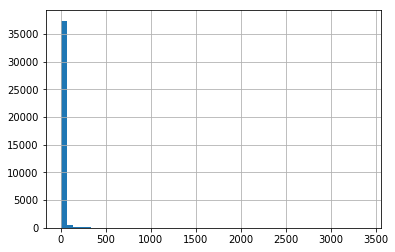

In [9]:
tags.tag.value_counts().hist(bins=50)

In [10]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 26744 unique movies


,movieId,tag
20679,20679,{cold war Ed Harris submarine atmospheric cold...
18216,18216,{}
19185,19185,{Cyril Frankel BD-R}
23017,23017,{}
16491,16491,{}
26395,26395,{}
1879,1879,{goofy humorous irreverent NOTHING GOES RIGHT ...
2516,2516,{Netflix Finland documentary dolphins document...
13604,13604,{}
2890,2890,{Sylvester Stallone no rec? Roger Spottiswoode...


In [11]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Jumanji (1995),Adventure Children Fantasy,1,3.5,1112486027,0,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
1,"City of Lost Children, The (Cité des enfants p...",Adventure Drama Fantasy Mystery SciFi,1,3.5,1112484676,1,{children Santa Claus dystopia abused children...,{children Santa Claus dystopia abused children...
2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery SciFi Thriller,1,3.5,1112484819,2,{post-apocalyptic psychology time travel Brad ...,{post-apocalyptic psychology time travel Brad ...


In [12]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer based on a true story serial killer; based on a true story long obsession serial killer based on a true story serial killer crime David Fincher investigation investigative journalism Jake Gyllenhaal long Mark Ruffalo Robert Downey Jr. serial killer slow Too long based on a true story detective investigation Journalist obsession David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr bad ending Jake Gyllenhaal length Robert Downey Jr adapted from:true story based on a true story ChloÃ« Sevigny David Fincher detective great character development investigative journalism Jake Gyllenhaal John Carroll Lynch long Mark Ruffalo mind games obsession Robert Downey Jr. serial killer police based on a true story detective investigation police serial killer based on a true story Robert Downey Jr serial killer Too long true story cinematography David Fincher stylized investigative journalism obsession police police based on a true story based on a true story crime obsessio

In [13]:
tags.query('movieId == 19849')

,title,genres,userId,rating,timestamp,movieId,tag,document
19849,"Waiting Game, The (2000)",Comedy,29879,2.5,1161368462,19849,{},{} Comedy


# TFIDF

In [14]:
cf = ContentFiltering(tags)

In [ ]:
#TO DO run and save tfisd matrix for autencoder with muc more features. 

# Item-User Collaborative Filtering

In [15]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn import cross_validation as cv

/anaconda3/envs/my-movie-recommender/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [339]:
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
ratings = pd.merge(movies, ratings, on="movieId", how="right")
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])
print(ratings.shape)
print("There are {} users.".format(len(ratings.userId.unique())))
print("There are {} movies.".format(len(ratings.movieId.unique())))
ratings.head()

(20000263, 6)
There are 138493 users.
There are 26744 movies.


,movieId,title,genres,userId,rating,timestamp
0,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821


In [340]:
ratings = ratings.sample(500000)
#remove users that rates less than n things. 
ratings = ratings.groupby('userId').filter(lambda x: len(x) >= 2)
#remove movies that only occure once
ratings = ratings.groupby('movieId').filter(lambda x: len(x) > 1)

#do a test train split
train, test = cv.train_test_split(ratings, test_size=0.2)

#drop users and movies from test that aren't in train
c = list(set(test.movieId).intersection(train.movieId))
test = test[test['movieId'].isin(c)]
c = list(set(test.userId).intersection(train.userId))
test = test[test['userId'].isin(c)]

print("There are {} observations in train.".format(train.shape[0]))
print("There are {}  observations in test.".format(test.shape[0]))
train.head()

There are 372092 observations in train.
There are 90893  observations in test.


,movieId,title,genres,userId,rating,timestamp
10672540,1419,Rocky V (1990),Action|Drama,27870,1.0,1013527081
15890168,3504,Horror of Dracula (Dracula) (1958),Horror,130685,3.0,1204240072
15637558,805,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,45769,5.0,1223561682
12576790,753,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,40152,2.5,1404430063
13681731,1119,Chicken Run (2000),Animation|Children|Comedy,4795,4.0,1029353483


In [341]:
90775/(372088 + 90775)

0.19611634544130768

In [342]:
train = train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train.index.tolist()
movie_index = train.columns.tolist()
print(train.shape)
train.head()

(74216, 9868)


movieId,0,1,2,3,4,5,6,7,8,9,...,20536,20687,20709,21273,21290,21489,22064,22163,22853,23206
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [343]:
train = csr_matrix(train.values)
train

<74216x9868 sparse matrix of type '<class 'numpy.float64'>'
	with 372092 stored elements in Compressed Sparse Row format>

In [344]:
U, sigma, Vt = svds(train, k=100) # k is the number of factors
sigma = np.diag(sigma)

In [345]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [346]:
predicted_ratings = pd.DataFrame(predicted_ratings, index=user_index, columns=movie_index)
#predicted_ratings = predicted_ratings.astype('int')
predicted_ratings.head(4)

,0,1,2,3,4,5,6,7,8,9,...,20536,20687,20709,21273,21290,21489,22064,22163,22853,23206
1,0.010706,0.006669,-0.006880,-0.009222,-0.001327,-0.002258,0.001626,0.042980,0.030692,0.022695,...,1.124528e-05,1.201013e-04,0.000518,0.000060,0.000117,0.000017,0.000060,7.435858e-05,0.000393,-0.000092
2,0.000180,0.000103,0.003100,0.003848,-0.000570,0.000209,0.000115,0.000730,0.000365,0.001229,...,3.725719e-07,1.060620e-07,-0.000003,0.000001,-0.000002,0.000001,-0.000001,-5.698857e-07,-0.000005,0.000007
3,0.018970,0.003286,0.026271,-0.016905,0.017769,0.005895,0.005820,0.054380,0.023595,0.044080,...,4.062858e-05,1.437491e-04,0.000495,0.000140,-0.000088,-0.000141,0.000114,-3.417261e-05,0.000179,-0.000029
7,0.004795,0.008698,-0.006457,-0.014721,0.014543,0.007269,0.002912,0.008993,-0.160597,0.011694,...,-3.525850e-05,-1.167897e-05,0.000078,-0.000066,-0.000200,0.000028,-0.000182,-1.095402e-05,-0.000262,0.000123


In [347]:
predicted_ratings.to_pickle("../data/collaborative_item_to_user_model.pkl")
#predicted_ratings = pd.read_pickle("../data/collaborative_item_to_user_model.pkl")
predicted_ratings.head(3)

OSError: [Errno 22] Invalid argument

In [619]:
demographics = pd.read_csv('../data/movie_demographics.csv')
demographics.set_index("movieId", inplace=True)
demographics = demographics[demographics.index.isin(ratings.movieId.tolist())]
demographics = demographics.sort_values("ratings_count", ascending=False)
demographics.head()

,title,genres,ratings_count,avg_rating
movieId,,,,
11,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231
369,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000
12,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990
17,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057
182,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741


In [349]:
#get recommended movies for user 3

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)
    recommended_items = recommended_items.head(n)

    recommended_items = pd.merge(demographics, recommended_items, left_index=True, right_index=True)
    recommended_items.sort_values('predicted_rating', ascending=False, inplace=True)
    recommended_items.reset_index(inplace=True)
    recommended_items = recommended_items.rename(index=str, columns={"index": "item_id"})
    #recommended_items = recommended_items.query('predicted_rating >= 3')
    return recommended_items

# Make mar@k and map@k plots

In [350]:
get_users_predictions(user_id=99522, n=20, model=predicted_ratings)

,item_id,title,genres,ratings_count,avg_rating,predicted_rating
0,7,Clerks (1994),Comedy,23695,3.869551,0.409211
1,8,Interview with the Vampire: The Vampire Chroni...,Drama|Horror,27568,3.496645,0.320752
2,630,Get Shorty (1995),Comedy|Crime|Thriller,24116,3.581689,0.293330
3,444,Sleepless in Seattle (1993),Comedy|Drama|Romance,28805,3.518417,0.267376
4,24,Monty Python's Life of Brian (1979),Comedy,20557,3.981126,0.258051
5,646,Ace Ventura: Pet Detective (1994),Comedy,38226,2.982342,0.257791
6,42,Dead Poets Society (1989),Drama,20538,3.893807,0.190293
7,38,Psycho (1960),Crime|Horror,19649,4.076900,0.187887
8,404,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,29488,3.443859,0.186412
9,446,Pretty Woman (1990),Comedy|Romance,33900,3.420428,0.178543


In [351]:
test.query('userId == 99522')

,movieId,title,genres,userId,rating,timestamp
11796163,91,"Christmas Story, A (1983)",Children|Comedy,99522,4.5,1353115183
9334441,67,"Exorcist, The (1973)",Horror|Mystery,99522,3.0,1353289772
9719033,1246,101 Dalmatians (One Hundred and One Dalmatians...,Adventure|Animation|Children,99522,4.5,1353257599
8687041,288,Titanic (1997),Drama|Romance,99522,3.0,1353376966


In [267]:
print(len(test.userId.unique().tolist()))

44829


In [541]:
pred_movies = []
actual_movies = []
test_users = test.userId.unique().tolist()
for i in test_users:
    pred_movies.append(get_users_predictions(user_id=i, n=20, model=predicted_ratings).item_id.tolist())
    actual_movies.append(test.query('userId == @i').movieId.tolist())

In [542]:
MAPK = []
for K in range(1, 21):
    MAPK.append(metrics.mapk(actual=actual_movies, predicted=pred_movies, k=K))
MAPK

[0.0014787596343430723,
 0.002184531278006811,
 0.0026463324769472824,
 0.0031219814881201335,
 0.0035015671366831966,
 0.0037712540578757644,
 0.00404207420705033,
 0.00429976306745737,
 0.004510124597751909,
 0.004733786597288468,
 0.0048619580073265365,
 0.005032882245216587,
 0.005172850240366964,
 0.005320145762937753,
 0.005437547860101329,
 0.005536211188356094,
 0.005650475483214402,
 0.005751239089735551,
 0.005840385604475927,
 0.005936153841616357]

In [543]:
MARK = []
for K in range(1, 21):
    MARK.append(mark(truth=actual_movies, recommendations=pred_movies, k=K))
MARK

[0.0010812762997294276,
 0.0025081263399622427,
 0.0038574804443463704,
 0.005536446525955175,
 0.00710321749161595,
 0.008440026420175191,
 0.009979594934479962,
 0.011596496812813419,
 0.013140042825050886,
 0.01490511524454646,
 0.016032247561917155,
 0.01762085061215264,
 0.019028771883971098,
 0.020705653517714813,
 0.02207733509365987,
 0.023285217442461602,
 0.02478175151038984,
 0.026196808553592486,
 0.027446807402658164,
 0.028952718707306094]

In [544]:
eval_df = pd.DataFrame([range(1, 21), MAPK, ["mapk"]*20]).T
eval_df= eval_df.append(pd.DataFrame([range(1, 21), MARK, ["mark"]*20]).T)
eval_df.columns= ['k', 'value', 'metric']
eval_df.k = eval_df.k.astype('int')
eval_df.value = eval_df.value.astype('float')
eval_df.dtypes

k           int64
value     float64
metric     object
dtype: object

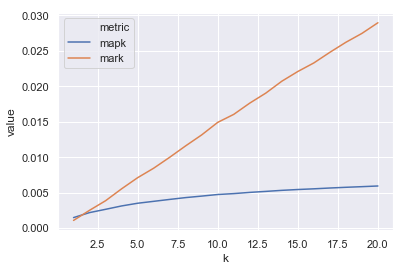

In [545]:
ax = sns.lineplot(x="k", y="value", hue="metric", data=eval_df)

In [273]:
def ark(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / len(actual)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mar_at_k(actual, predicted, k=10):
    return np.mean([ark(a,p,k) for a,p in zip(actual, predicted)])

def mark(truth, recommendations, k=5):

    if isinstance(k, (list, np.ndarray)):

        # Compute mapk for a range of k values
        return [mar_at_k(truth, recommendations, k=i) for i in k]

    return mar_at_k(truth, recommendations, k=k)

In [ ]:
#I think what I'm really tyring to answer here is, what porportion of my movies are NEVER recommended. 
#OR Never correctly recommended

In [552]:
pred_movies
flat_pred_movies = [item for sublist in pred_movies for item in sublist]
flat_pred_movies

[1352,
 34,
 724,
 148,
 314,
 574,
 808,
 719,
 7,
 27,
 803,
 1372,
 111,
 163,
 400,
 628,
 1536,
 10,
 9,
 173,
 3,
 484,
 574,
 1536,
 582,
 724,
 628,
 808,
 1638,
 855,
 8,
 10,
 382,
 1341,
 7,
 803,
 40,
 367,
 267,
 626,
 17,
 3,
 142,
 382,
 367,
 1007,
 1949,
 180,
 267,
 42,
 114,
 839,
 551,
 480,
 376,
 13,
 952,
 719,
 0,
 633,
 242,
 414,
 376,
 630,
 81,
 1056,
 1381,
 648,
 1127,
 1046,
 582,
 235,
 671,
 1408,
 1047,
 739,
 176,
 647,
 323,
 138,
 1209,
 1536,
 582,
 364,
 7,
 444,
 843,
 803,
 1372,
 1098,
 998,
 480,
 87,
 265,
 647,
 1638,
 367,
 257,
 1294,
 818,
 1332,
 574,
 11,
 245,
 93,
 364,
 38,
 276,
 440,
 1081,
 8,
 2016,
 7,
 148,
 724,
 1340,
 913,
 1242,
 511,
 419,
 392,
 808,
 148,
 484,
 768,
 448,
 843,
 724,
 96,
 1372,
 0,
 88,
 633,
 681,
 414,
 644,
 118,
 163,
 481,
 1046,
 652,
 9,
 88,
 20,
 15,
 44,
 998,
 82,
 8,
 1341,
 1999,
 125,
 1085,
 913,
 114,
 86,
 111,
 1064,
 1353,
 1100,
 410,
 251,
 276,
 1536,
 22,
 444,
 19,
 400,
 446,
 

In [627]:
pred_movies_df = pd.DataFrame(flat_pred_movies)
pred_movies_df.columns = ["number_of_recs"]
pred_movies_df = pd.DataFrame(pred_movies_df.number_of_recs.value_counts())
pred_movies_df.head(3)

,number_of_recs
7,18099
8,15018
444,13464


In [628]:
demographics.head()

,title,genres,ratings_count,avg_rating
movieId,,,,
11,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231
369,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000
12,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990
17,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057
182,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741


In [629]:
test_demographics = pd.merge(demographics, pred_movies_df, left_index=True, right_index=True, how="inner")
test_demographics = demographics.fillna(0)
test_demographics.head(3)

,title,genres,ratings_count,avg_rating
movieId,,,,
11,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231
369,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000
12,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990


In [622]:
test_demographics = test_demographics[test_demographics.index.isin(test.movieId.values.tolist())]

In [ ]:
test_demographics.head()

In [624]:
ax = sns.lineplot(x="ratings_count", y="number_of_recs", data=test_demographics)

ValueError: Could not interpret input 'number_of_recs'

In [ ]:
# TO DO 
precision recall for high volume an dlow volume movies
multivariation preccion and recall 
confusion matrix
precision recall by movie volume scatter plot
% of movies we every recommend. 
% of movies we ever recommend correctly
mark and mapk. How does pop bias show up in these?
What metric showspop bias? 
Adjusting rec threshold by volume of movie help?

In [ ]:

TODO

1.  Ok. So. To truely understand precision and recall relationship with volume, I need to plot precisiona and recall by volume
2 Then, is it somehow different for map@k? 
3. Pick an metric or combo of metrics that is showing if your model is pop bias or not.  
4. See if changing the recommendation score threhsold for lower volume movies helps? I.e. a lower rec score for low volume movie results in still making that rec.
Basically, weight rec score by volume. This is parallel to adjusting the classification threshold for a 0 1 classification. 

# Our Long Tail

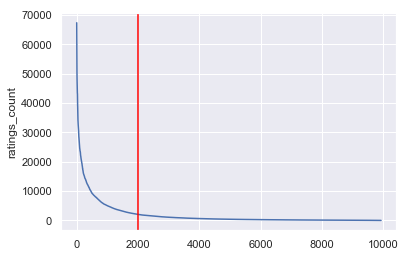

In [352]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x=range(0,len(demographics)), y="ratings_count", data=demographics)
plt.axvline(x=2000, color="red")

In [353]:
#How much volume is the head and tail?

print("{} percent of all movies are in the head".format(
        demographics.query('ratings_count > 2000').shape[0]/demographics.shape[0]))

print("{} percent of all movies are in the tail".format(
        demographics.query('ratings_count < 2000').shape[0]/demographics.shape[0]))

demographics.head()

total_volume = demographics.ratings_count.sum()
print("Our head consists of {} percent of all volume".format(
    demographics.query('ratings_count > 2000').ratings_count.sum()/total_volume))
print("Our tail consists of {} percent of all volume".format(
    demographics.query('ratings_count < 2000').ratings_count.sum()/total_volume))

#So, 81% of our volume is explained by only 20% of our movies

0.20471014492753623 percent of all movies are in the head
0.7951892109500805 percent of all movies are in the tail
Our head consists of 0.8185037715071234 percent of all volume
Our tail consists of 0.1813950315967069 percent of all volume


# Precision and Recall in the Head and Tail

In [354]:
#Find average precision and recall for the head
#Find average precision and recall for the tail.

In [355]:
our_head = demographics.query('ratings_count > 2000')
print(our_head.shape)
our_head.head(3)

(2034, 4)


,title,genres,ratings_count,avg_rating
movieId,,,,
11,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231
369,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000
12,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990


In [356]:
our_tail = demographics.query('ratings_count < 2000')
our_tail.shape
our_tail.sample(3)

,title,genres,ratings_count,avg_rating
movieId,,,,
6383,"Libertine, The (2004)",Drama,447,3.022371
2288,Runaway Train (1985),Action|Adventure|Drama|Thriller,1676,3.519093
6567,Torch Song Trilogy (1988),Comedy|Drama|Romance,434,3.834101


# Popular vrs Niche Movie

In [484]:
#Find a popular movie and look at precision and recall (LOTR)
#Find a niche movie and look at precision and recall (Primer)

90893

In [500]:
demographics.query('title == "Talented Mr. Ripley, The (1999)"')

,title,genres,ratings_count,avg_rating
movieId,,,,
551,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,13563,3.484037


In [501]:
test.title.value_counts().head()

Pulp Fiction (1994)                          280
Forrest Gump (1994)                          278
Silence of the Lambs, The (1991)             270
Shawshank Redemption, The (1994)             254
Star Wars: Episode IV - A New Hope (1977)    244
Name: title, dtype: int64

In [502]:
sample_movies = demographics[demographics['title'].isin(["Talented Mr. Ripley, The (1999)", "Lord of the Rings: The Fellowship of the Ring, The (2001)"])]
sample_movies

,title,genres,ratings_count,avg_rating
movieId,,,,
131,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,37553,4.137925
551,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,13563,3.484037


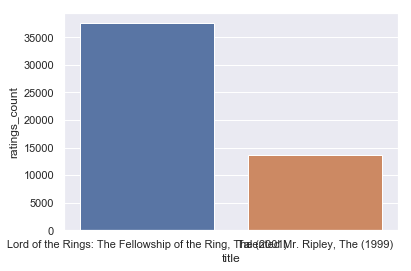

In [503]:
sns.barplot(x=sample_movies.title, 
            y=sample_movies.ratings_count)

## Classifier Precision

In [455]:
#This gets all observations where LOTR was either predicted or true
#It is recorded every time it is predicted and true.
#Other movies are all ignored and not recorded 

#calcuate basic precision and recall as if it is a classifier
#Classiifier predicts 131, LOTR, or 0, Not LOTR

pred_movies_lotr = []
actual_movies_lotr = []
m = 131
test_users = test.userId.unique().tolist()
for i in test_users:
    pred_list = get_users_predictions(user_id=i, n=20, model=predicted_ratings).item_id.tolist()
    true_list = test.query('userId == @i').movieId.tolist()
    if (m in pred_list) and (m in true_list):
        pred_movies_lotr.extend([1])
        actual_movies_lotr.extend([1])
    if (m in pred_list) and (m not in true_list):
        pred_movies_lotr.extend([1])
        actual_movies_lotr.extend([0])
    if (m not in pred_list) and (m in true_list):
        pred_movies_lotr.extend([0])
        actual_movies_lotr.extend([1])

In [461]:
from sklearn.metrics import precision_score, recall_score

# Precision
# no. correct positive / no. predicted positive
#how many times I recommended LOTR correctly, out of all the times I recommended LOTR
# There is a high number of predicted postives for LOTR, but it is rearely in the true data, so precision is low. 
#A low precision value means for a high volume items means your recs are pop bias. 

y_true = actual_movies_lotr
y_pred = pred_movies_lotr
precision_score(y_true, y_pred)

0.002607561929595828

In [457]:
# Recall
# no. correct positive / no. true positive
#How many times I recommented LOTR, out of all the times LOTR was right. 
# This will be high for pop bias movies. 

y_true = actual_movies_lotr
y_pred = pred_movies_lotr
recall_score(y_true, y_pred)

0.026490066225165563

In [ ]:
#The problem with our recommender is
#1. It never recommends low volume items (niche) like primer
#2. It recommends high volume items like LOTR WAY more times than is relevant. 
# In a pop bias recommender, recall will be much higher than precision because you a recommending popular items a lot, 
#so you recall all the popular items, but you are wrong about your pop recs a lot of the time. 
#Is that true?

In [ ]:
#What metrics can I use to show this?
# Look at precision and Recall plotted by volume of movie. Is there a trend?

# Map@k and Mar@k for a recommender

In [505]:
pred_movies_lotr = []
actual_movies_lotr = []
m = 131
test_users = test.userId.unique().tolist()
for i in test_users:
    pred_list = get_users_predictions(user_id=i, n=20, model=predicted_ratings).item_id.tolist()
    true_list = test.query('userId == @i').movieId.tolist()
    if (m in pred_list) or (m in true_list):
        pred_movies_lotr.append(pred_list)
        actual_movies_lotr.append(true_list)

In [506]:
pred_movies_lotr

[[131,
  453,
  25,
  42,
  539,
  59,
  245,
  24,
  267,
  719,
  1732,
  364,
  173,
  1079,
  49,
  38,
  271,
  1236,
  404,
  417],
 [158,
  25,
  828,
  1536,
  264,
  131,
  724,
  302,
  719,
  34,
  1124,
  385,
  440,
  803,
  15,
  998,
  628,
  407,
  582,
  467],
 [14,
  647,
  367,
  263,
  22,
  440,
  646,
  448,
  444,
  1340,
  17,
  242,
  2,
  131,
  511,
  233,
  111,
  276,
  32,
  227],
 [855,
  191,
  131,
  803,
  444,
  38,
  163,
  45,
  7,
  913,
  1081,
  1079,
  939,
  113,
  2087,
  93,
  269,
  839,
  173,
  998],
 [131,
  22,
  27,
  245,
  59,
  7,
  51,
  367,
  483,
  276,
  410,
  67,
  657,
  189,
  42,
  34,
  191,
  494,
  69,
  247],
 [131,
  1341,
  400,
  276,
  444,
  647,
  719,
  93,
  38,
  7,
  245,
  271,
  446,
  630,
  404,
  8,
  19,
  1353,
  828,
  646],
 [1332,
  855,
  191,
  7,
  119,
  186,
  408,
  10,
  1352,
  251,
  1353,
  131,
  11,
  1209,
  405,
  8,
  45,
  29,
  582,
  242],
 [264,
  3,
  131,
  1081,
  582,
  245,
  

In [507]:
actual_movies_lotr

[[839, 9041, 2791],
 [1959],
 [4890],
 [1083, 3625, 158, 769, 1084, 659],
 [1386, 533, 3381],
 [1124, 38],
 [1720],
 [1294, 1234],
 [637, 15, 724, 1277],
 [158, 6014],
 [1209, 4153, 7289, 3036],
 [163, 651, 131],
 [4872, 1639, 5708, 6376, 1614, 6843, 7708],
 [131],
 [3585, 1050, 287, 435, 1556, 798, 1835],
 [1595, 27],
 [1403, 1426],
 [9705],
 [430],
 [275],
 [1341, 90],
 [217],
 [634, 2382, 1417, 81, 387],
 [927, 7487],
 [1265, 1744, 178, 2551, 1997, 3776, 10721, 1288, 1211, 5371, 2151, 4938],
 [6345, 279, 2335, 1932],
 [1241, 464],
 [17],
 [10470, 3715, 131, 6565, 570, 416, 9717, 6957, 1215, 4871],
 [302, 4828],
 [131, 2258, 781, 1983],
 [757, 80, 2117, 7546, 1498],
 [186, 1638, 261],
 [131, 3046, 1529, 2088],
 [853],
 [93, 2276, 2245, 6397, 457, 809, 1281],
 [853],
 [673, 547, 3492, 1079, 3431, 205, 5161],
 [338],
 [988, 171, 1345],
 [1284, 1335, 348],
 [131],
 [2153, 4225, 1636, 131, 4668, 2066, 1654],
 [186],
 [1275, 3992],
 [1259, 1233, 131],
 [1814, 67, 387],
 [818, 808],
 [5676

In [521]:
MAPK = []
for i in range(1, 20):
    MAPK.extend([metrics.mapk(actual=actual_movies_lotr, predicted=pred_movies_lotr, k=i)])
MAPK

[0.00297441998810232,
 0.00297441998810232,
 0.0033710093198492963,
 0.003544517152488598,
 0.0038300614713464216,
 0.003934496662039791,
 0.004321171260493093,
 0.004457498843281116,
 0.004839924270322843,
 0.005122494169192563,
 0.005374869198486093,
 0.005564901586614853,
 0.005690742432265336,
 0.0059244468599019455,
 0.0060678800015504354,
 0.006160830626178632,
 0.006258311617385347,
 0.0063464425799957865,
 0.006492554439060463]

In [540]:
MARK = []
for i in range(1, 20):
    MARK.extend([mark(truth=actual_movies_lotr, recommendations=pred_movies_lotr, k=i)])
MARK

[0.0021670774199031187,
 0.002868190702812951,
 0.004192515792753746,
 0.004929038837426702,
 0.00589112206453075,
 0.006543133811129052,
 0.009104524220951518,
 0.009914227439934926,
 0.012764207408126843,
 0.015329644647865095,
 0.017874426193241526,
 0.01987389740746586,
 0.02095212465315295,
 0.023777823641850156,
 0.024978993580378812,
 0.026317482575024857,
 0.027680252549165608,
 0.02873782410049088,
 0.030952114536078164]

In [538]:
# wow ok so
#1. primer is literally never recommended. wrong or right, its never a rec
#2. and WOWWW we have some pop bias. Lotr is predicted WAY More than it is accurate.

#how many times was lotr right?
lotr_right = len(test.query('movieId == 131'))
print("LOTR was right {} times".format(lotr_right))

#and how many times was it predicted?
lotr_recommended = 0
for i in range(len(pred_movies_lotr)):
    if 131 in pred_movies_lotr[0]:
        lotr_recommended = lotr_recommended + 1
print("LOTR was predicted {} times".format(lotr_recommended))

print ("LOTR made up {} percent of predictions".format(lotr_recommended/len(test)))

LOTR was right 151 times
LOTR was predicted 1681 times
LOTR made up 0.018494273486407094 percent of predictions
